In [1]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import torch
import cv2
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.autograd.variable import Variable

In [2]:
# Remove all warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
tf.keras.datasets.mnist.load_data(path="mnist.npz")
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print("X_train shape # {} ".format(X_train.shape),'\n')
print("X_test shape  # {} ".format(X_test.shape),'\n')
print("y_train shape # {} ".format(y_train.shape),'\n')
print("y_test shape  # {} ".format(y_test.shape))

11490434/11490434 [==============================] - 1s 0us/step
X_train shape # (60000, 28, 28)  

X_test shape  # (10000, 28, 28)  

y_train shape # (60000,)  

y_test shape  # (10000,) 


In [44]:
X = []
for image in X_train:
  X.append(cv2.resize(image, (10, 10)))

X = np.array(X)

In [5]:
X.shape

(60000, 10, 10)

In [6]:
# Merged the dataset so that we can dataset
DATA  = np.concatenate((X_train, X_test), axis = 0)
LABEL = np.concatenate((y_train, y_test), axis = 0)

print("Data shape   # {} ".format(DATA.shape),'\n')
print("Label shape  # {} ".format(LABEL.shape))

Data shape   # (70000, 28, 28)  

Label shape  # (70000,) 


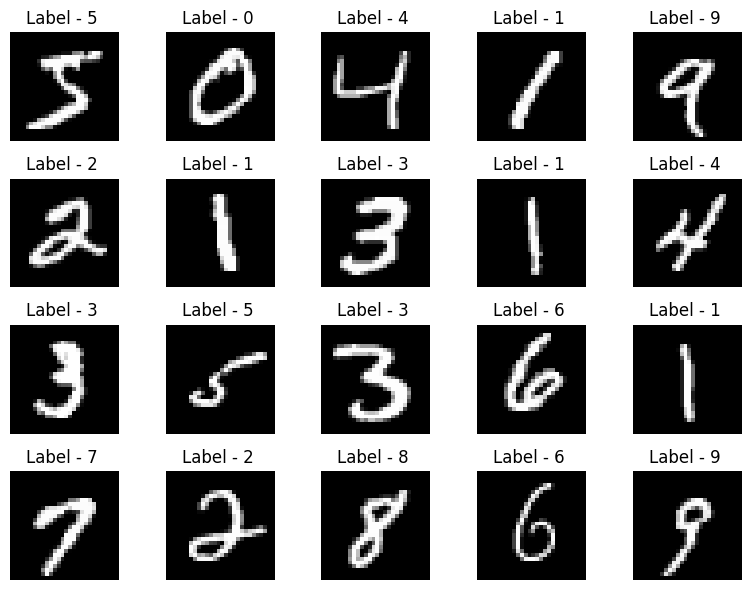

In [7]:
# Take only 20 data from independent & dependent
IMAGE  = DATA[0:20]

#Change the shape of the Image
IMAGE  = IMAGE.reshape(IMAGE.shape[0], 28, 28, 1)
TARGET = LABEL[0:20]
plt.figure(figsize = (8, 6))

# Dispplay the Image
for index, image in enumerate(IMAGE):
  plt.subplot(4, 5, index + 1)
  plt.title('Label - {} '.format(TARGET[index]))
  plt.imshow(image, cmap = 'gray')
  plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Initialize some variables with BACTH_SIZE
X = X_train.reshape(X_train.shape[0], -1)
X = X / 255
y = y_train
BATCH_SIZE = 64

# Change the data-type in accordance with Torch
X = torch.tensor(data = X, dtype = torch.float32)
y = torch.tensor(data = y, dtype = torch.float32)

# Call the DataLoader
TRAIN_LOADER = DataLoader(
    dataset = list(zip(X, y)), batch_size = BATCH_SIZE, shuffle = True
)

# Iterate througout the Train Loader
data, labels = next(iter(TRAIN_LOADER))

print("Batch size # {} ".capitalize().format(TRAIN_LOADER.batch_size),'\n')
print("Train data shape with batch_size  # {} ".format(data.shape),'\n')
print("Train label shape with batch_size # {} ".format(labels.shape))

Batch size # 64  

Train data shape with batch_size  # torch.Size([64, 784])  

Train label shape with batch_size # torch.Size([64]) 


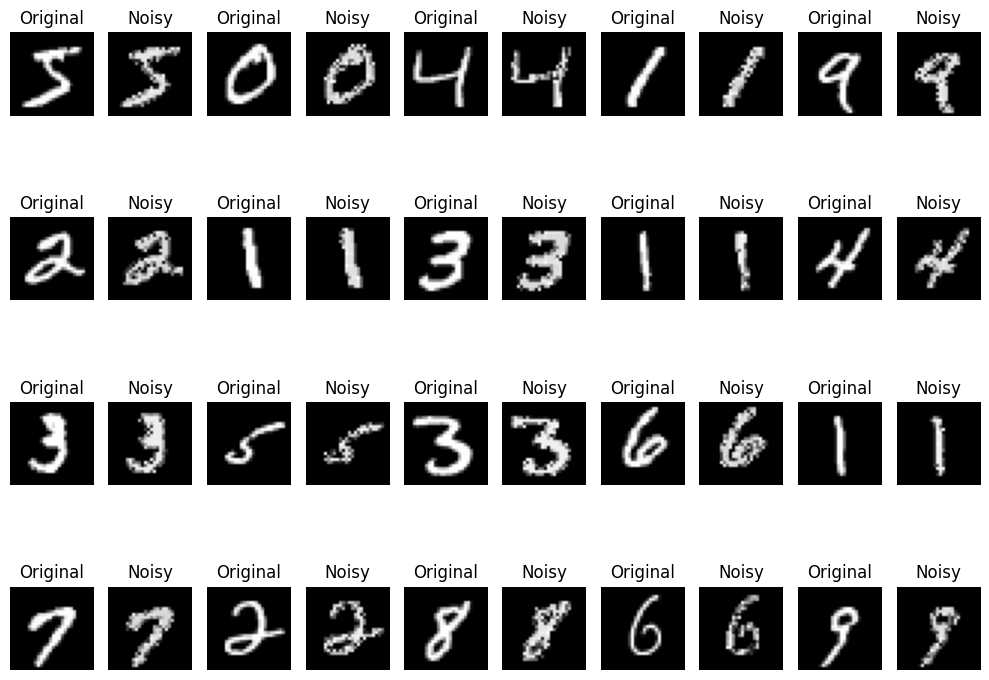

In [51]:
# NOISE_FACTOR defined
NOISE_FACTOR = 10

# Generate Gaussian noise
gaussian_noise = NOISE_FACTOR * DATA[0:20]

# Add random noise to images
NOISE_IMAGE = gaussian_noise

# Display the original and noisy images
plt.figure(figsize=(10, 8))

for index, (original, noisy) in enumerate(zip(DATA[0:20], NOISE_IMAGE)):
    plt.subplot(4, 10, index * 2 + 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(4, 10, index * 2 + 2)
    plt.imshow(noisy, cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

plt.tight_layout()
plt.show()


#####Import the dataset from Torch

In [10]:
from torchvision import transforms, datasets

def mnist_data():
    '''
    Prepare the MNIST dataset with required transformations.

    Returns:
    datasets.MNIST: MNIST dataset with appropriate transformations.
    '''
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# Load data
'''
Load the MNIST dataset using the provided mnist_data function.
Set the batch size for processing multiple samples in parallel.
Create a DataLoader to handle batch loading and shuffling of the data.
'''
data = mnist_data()
BATCH_SIZE = 100
DATA_LOADER = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

'''
Calculate the number of batches in the DataLoader.
This value is useful for tracking progress during training.
'''
num_batches = len(DATA_LOADER)

100%|██████████| 9912422/9912422 [00:00<00:00, 445412689.30it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 5872391.60it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 260103478.75it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20331407.44it/s]


Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("The device is {} ".format(device).title())

The Device Is Cuda 


In [13]:
class Generator(nn.Module):
    """
    A three hidden-layer generative neural network
    takes a latent variable vector as input and returns a 784-valued vector,
    with values in the (-1, 1) range. This vector corresponds to a flattened 28x28 image.
    """
    def __init__(self):
        super(Generator, self).__init__()

        self.model = self.fc_block()

    def fc_block(self, input_feature = None, output_dimension = None):
        """
        Create the fully connected block for the generator.

        Args:
            input_feature (int): Number of input features (optional).
            output_dimension (int): Output dimension (optional).

        Returns:
            Sequential: A sequence of layers representing the generator block.
        """
        return nn.Sequential(
            nn.Linear(in_features = 100, out_features = 256),
            nn.LeakyReLU(0.2),

            nn.Linear(in_features = 256, out_features = 512),
            nn.LeakyReLU(0.2),

            nn.Linear(in_features = 512, out_features = 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(in_features = 1024, out_features = 784),
            nn.Tanh()
        )

    def forward(self, x):
        """
        Forward pass of the generator.

        Args:
            x (Tensor): Input latent variable vector.

        Returns:
            Tensor: Output generated data vector.
        """
        x = self.model(x)
        return x


In [14]:
# Call the model
generator = Generator().to(device)

print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


In [15]:
# Connect GPU
generator = generator

TRAINABLE_PARAMS = 0
for name, params in generator.named_parameters():
  if params.requires_grad == True:
    print("Layer - {} & trainable parameters # {} ".capitalize().format(name, params.numel()),'\n')
    TRAINABLE_PARAMS+= params.numel()

print("Total Trainable parameters # {} ".upper().format(TRAINABLE_PARAMS))

Layer - model.0.weight & trainable parameters # 25600  

Layer - model.0.bias & trainable parameters # 256  

Layer - model.2.weight & trainable parameters # 131072  

Layer - model.2.bias & trainable parameters # 512  

Layer - model.4.weight & trainable parameters # 524288  

Layer - model.4.bias & trainable parameters # 1024  

Layer - model.6.weight & trainable parameters # 802816  

Layer - model.6.bias & trainable parameters # 784  

TOTAL TRAINABLE PARAMETERS # 1486352 


In [17]:
class Discriminator(nn.Module):
    """
    A three hidden-layer discriminative neural network
    This network takes a flattened image as its input,
    and returns the probability of it belonging to the real dataset or the synthetic dataset.
    """
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = self.fc_block()

    def fc_block(self, input_feature = None, output_dimension = None):
        """
        Create the fully connected block for the discriminator.

        Args:
            input_feature (int): Number of input features (optional).
            output_dimension (int): Output dimension (optional).

        Returns:
            Sequential: A sequence of layers representing the discriminator block.
        """
        return nn.Sequential(
            nn.Linear(in_features = 784, out_features = 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(in_features = 1024, out_features = 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(in_features = 512, out_features = 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(in_features = 256, out_features = 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass of the discriminator.

        Args:
            x (Tensor): Input data.

        Returns:
            Tensor: Output probability tensor.
        """
        x = self.model(x)
        return x


In [18]:
discriminator = Discriminator().to(device)

In [19]:
TRAINABLE_PARAMS = 0
for name, params in discriminator.named_parameters():
  if params.requires_grad == True:
    print("Layer - {} & trainable parameters # {} ".capitalize().format(name, params.numel()),'\n')
    TRAINABLE_PARAMS+= params.numel()

print("Total Trainable parameters # {} ".upper().format(TRAINABLE_PARAMS))

Layer - model.0.weight & trainable parameters # 802816  

Layer - model.0.bias & trainable parameters # 1024  

Layer - model.3.weight & trainable parameters # 524288  

Layer - model.3.bias & trainable parameters # 512  

Layer - model.6.weight & trainable parameters # 131072  

Layer - model.6.bias & trainable parameters # 256  

Layer - model.9.weight & trainable parameters # 256  

Layer - model.9.bias & trainable parameters # 1  

TOTAL TRAINABLE PARAMETERS # 1460225 


In [20]:
LEARNING_RATE = 0.0002

loss_function = nn.BCELoss()
optimizer_discriminator = optim.Adam(params = discriminator.parameters(), lr = LEARNING_RATE)
optimizer_generator     = optim.Adam(params = generator.parameters(), lr = LEARNING_RATE)

print("Optimizer of Discriminator.\n\n{} ".format(optimizer_discriminator),'_'*50,'\n')
print("Optimizer of Generator.\n\n{} ".format(optimizer_generator))

Optimizer of Discriminator.

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)  __________________________________________________ 

Optimizer of Generator.

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
) 


In [21]:
def target_ones(batch_size = None):
    '''
    Generate a tensor of ones as target labels.

    Args:
        batch_size (int): Number of samples in the batch.
        dimension (int): Number of dimensions for each sample.

    Returns:
        Tensor: Tensor of ones with the specified shape.
    '''
    return Variable(torch.ones(batch_size, 1)).to(device)

def target_zeros(batch_size=None):
    '''
    Generate a tensor of zeros as target labels.

    Args:
        batch_size (int): Number of samples in the batch.
        dimension (int): Number of dimensions for each sample.

    Returns:
        Tensor: Tensor of zeros with the specified shape.
    '''
    return Variable(torch.zeros(batch_size, 1)).to(device)

In [22]:
# Training Loop
EPOCHS = 200
DISCRIMINATOR_LOSS = []
GENERATOR_LOSS = []

for epoch in range(EPOCHS):
    total_discriminator_loss = []
    total_generator_loss     = []

    # Iterate over the dataset
    for real_data, real_labels in DATA_LOADER:
        batch_size = real_data.size(0)

        # Prepare real data
        ''''
          Extract the batch size from the real data tensor.
          This will be used to manage the batch processing.
        '''
        # Get the real data onto the device and reshape it
        ''''
          Move the real data tensor to the specified device (e.g., GPU)
          for computation and reshape it to have a flat feature space.
        '''
        real_samples = real_data.to(device)
        real_samples = real_samples.reshape(real_samples.shape[0], -1)

        # Create real labels
        ''''
          Generate the target labels for real data samples.
          These labels are set to indicate genuine data.
        '''
        real_labels = target_ones(batch_size=batch_size)

        ''''
          Generate random noise samples as input for the generator.
          These samples will be transformed into fake data by the generator.
          Also, generate target labels indicating fake data.
        '''
        fake_samples = Variable(torch.randn(batch_size, 100)).to(device)
        fake_labels  = target_zeros(batch_size=batch_size)

        ''''
          Clear the gradients and perform the backpropagation for the discriminator.
          Calculate the loss for real and fake samples separately,
          and then update the discriminator's parameters using the gradients.
        '''
        optimizer_discriminator.zero_grad()

        real_prediction = discriminator(real_samples)
        real_loss = loss_function(real_prediction, real_labels)
        real_loss.backward()

        fake_generated  = generator(fake_samples)
        fake_prediction = discriminator(fake_generated)
        fake_loss = loss_function(fake_prediction, fake_labels)
        fake_loss.backward()

        optimizer_discriminator.step()

        total_loss = real_loss + fake_loss
        total_discriminator_loss.append(total_loss.item())

        ############################
        #         Generator        #
        ############################

        ''''
          Clear the gradients and perform the backpropagation for the generator.
          Generate fake samples using the generator,
          and calculate the loss using the discriminator's prediction on fake data.
          Update the generator's parameters using the gradients.
        '''
        fake_generated = generator(fake_samples)

        optimizer_generator.zero_grad()

        fake_prediction = discriminator(fake_generated)

        generated_loss = loss_function(fake_prediction, real_labels)
        generated_loss.backward()
        optimizer_generator.step()

        total_generator_loss.append(generated_loss.item())

    # Calculate and store average losses for the epoch
    DISCRIMINATOR_LOSS.append(np.array(total_discriminator_loss).mean())
    GENERATOR_LOSS.append(np.array(total_generator_loss).mean())

    ##########################
    #         Display        #
    ##########################
    print("Epoch - {}/{} ".format(epoch + 1, EPOCHS))
    print("{}/{} [=================] Discriminator_loss: {:.4f} - Generator_loss: {:.4f}".format(batch_size, batch_size, \
                                                                                                np.array(total_discriminator_loss).mean(), \
                                                                                                np.array(total_generator_loss).mean()))


Epoch - 1/200 
100/100 [=================] Discriminator_loss: 1.1153 - Generator_loss: 2.2532
Epoch - 2/200 
100/100 [=================] Discriminator_loss: 1.1409 - Generator_loss: 1.4698
Epoch - 3/200 
100/100 [=================] Discriminator_loss: 1.1090 - Generator_loss: 1.5717
Epoch - 4/200 
100/100 [=================] Discriminator_loss: 0.8569 - Generator_loss: 2.2461
Epoch - 5/200 
100/100 [=================] Discriminator_loss: 0.5552 - Generator_loss: 2.7012
Epoch - 6/200 
100/100 [=================] Discriminator_loss: 0.6034 - Generator_loss: 2.5006
Epoch - 7/200 
100/100 [=================] Discriminator_loss: 0.6580 - Generator_loss: 2.2418
Epoch - 8/200 
100/100 [=================] Discriminator_loss: 0.7725 - Generator_loss: 1.9916
Epoch - 9/200 
100/100 [=================] Discriminator_loss: 0.6797 - Generator_loss: 2.0977
Epoch - 10/200 
100/100 [=================] Discriminator_loss: 0.7680 - Generator_loss: 1.9742
Epoch - 11/200 
100/100 [=================] Discr

######Display some of the Images

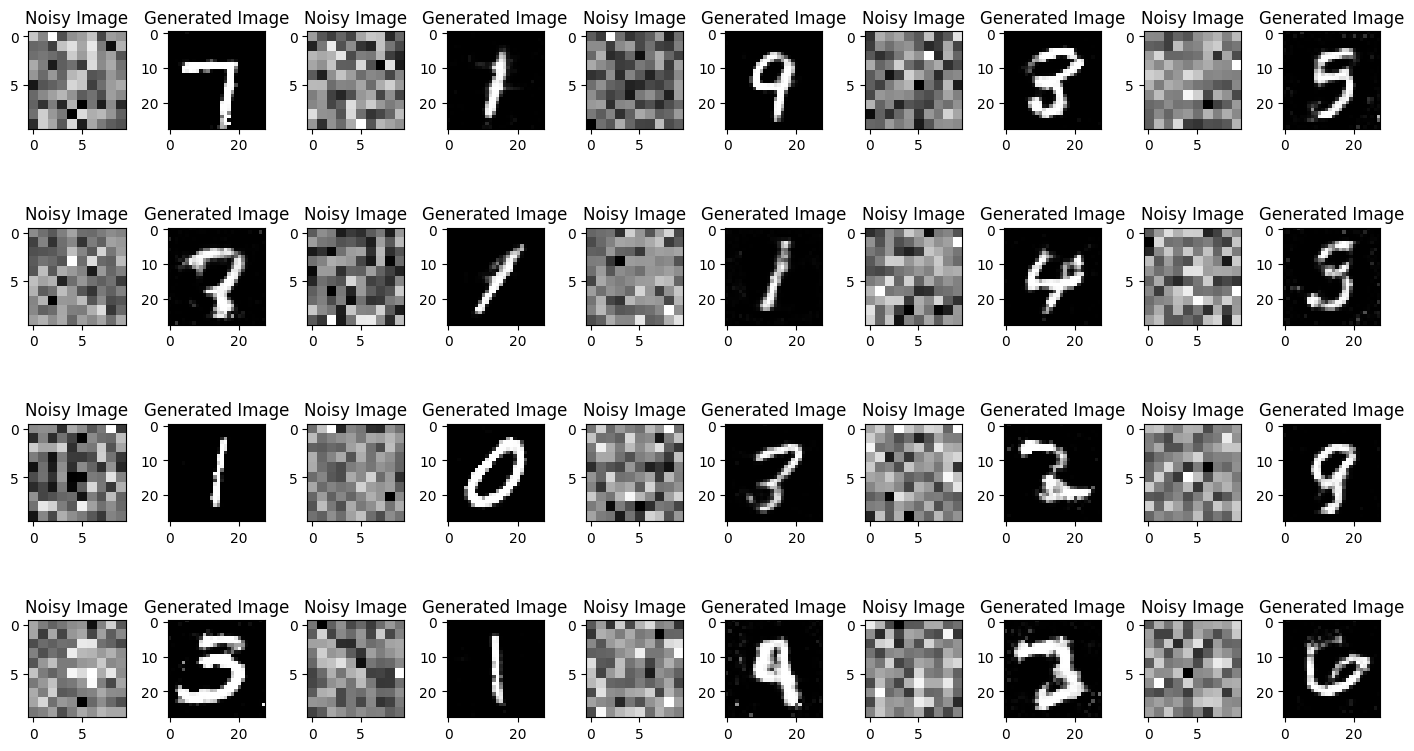

In [62]:
# Create random noise data
'''
Generate random noise data of shape (20, 10, 10).
Reshape the noise data to have a flat feature space.
Move the reshaped noise data to the specified device (e.g., GPU).
'''
NOISE_DATA = torch.randn(20, 10, 10)
NOISE_DATA = NOISE_DATA.reshape(NOISE_DATA.shape[0], -1).to(device)

# Generate images using the generator
'''
Pass the noise data through the generator to create generated images.
The resulting GENERATED tensor contains the generated images.
'''
GENERATED = generator(NOISE_DATA)

# Plot the noisy and generated images
plt.figure(figsize=(14, 10))
for index, (noise_image, generated_image) in enumerate(zip(NOISE_DATA, GENERATED)):
    # Plot the noisy image
    plt.subplot(4, 10, index * 2 + 1)
    plt.title('Noisy Image')

    # Reshape the noise image for visualization
    latent_image = noise_image.reshape(10, 10, 1)
    plt.imshow(latent_image.cpu().detach().numpy(), cmap='gray')

    # Plot the generated image
    plt.subplot(4, 10, index * 2 + 2)
    plt.title('Generated Image')

    # Reshape the generated image for visualization
    created_image = generated_image.reshape(28, 28, 1)
    plt.imshow(created_image.cpu().detach().numpy(), cmap='gray')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
